EDA

Our main objective is to answer key questions about the usage of counties data:

1) How the deforestation process correlates with counties borders?
    Are there counties that concentrates deforestation ocurrences? Some county agg data could be a useful input to the model?

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import box

import config
from utils import compute_frames

In [2]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [3]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [4]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

In [6]:
# counties data
counties = gpd.read_file('C:\\Users\\GiovanniAmorim\\Pessoal\\Mestrado\\DL2CV\\data\\raw\\municipios')

# filter counties thta intersects with amazon borders
counties = counties[counties.intersects(am_bounds["geometry"].item())].copy()

In [79]:
counties.shape

(807, 7)

## Are there counties that concentrates deforestation ocurrences?

In [80]:
frames = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 400, 800, 200, 600)
frames.shape

(160000, 4)

<Axes: >

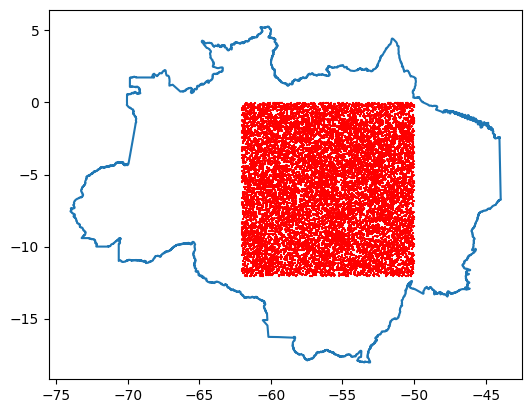

In [82]:
fig, ax = plt.subplots()
frames.sample(frac=0.1).boundary.plot(ax=ax, color="red")
am_bounds.boundary.plot(ax=ax)

In [85]:
region = gpd.overlay(
    frames.sample(frac=0.1), 
    counties[["NM_MUN", "SIGLA_UF", "populacao", "densidade", "geometry"]],
    how="intersection", 
    keep_geom_type=False
)
region["aprox_ar"] = region.geometry.area

C:\Users\GiovanniAmorim\AppData\Local\Temp\ipykernel_16804\3049152669.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4674

  region = gpd.overlay(


In [87]:
# keep only biggest intersection by frame id
region = region.\
    sort_values("aprox_ar", ascending=False).\
    drop_duplicates(subset="frame_id", keep="first")

In [88]:
df = pd.merge(
    region,
    deforestation,
    on="frame_id",
    how="left",
    validate="1:m"
)

c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


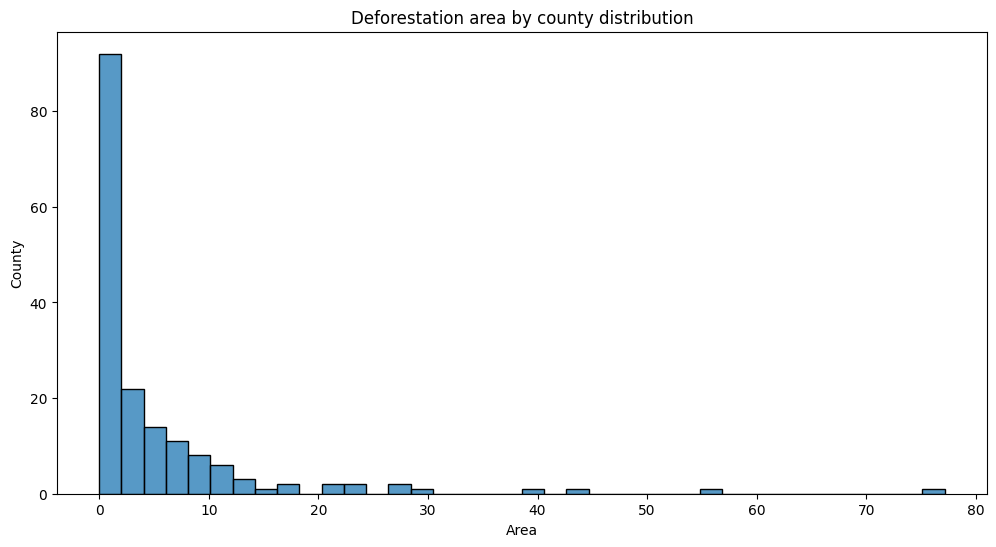

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(df.groupby("NM_MUN")["area"].sum())
ax.set_title("Deforestation area by county distribution")
ax.set_xlabel("Area")
ax.set_ylabel("County")
plt.show()

## Some county agg data could be a useful input to the model?

In [100]:
# using sample of counties data
df["NM_MUN"].nunique()

170

c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:111

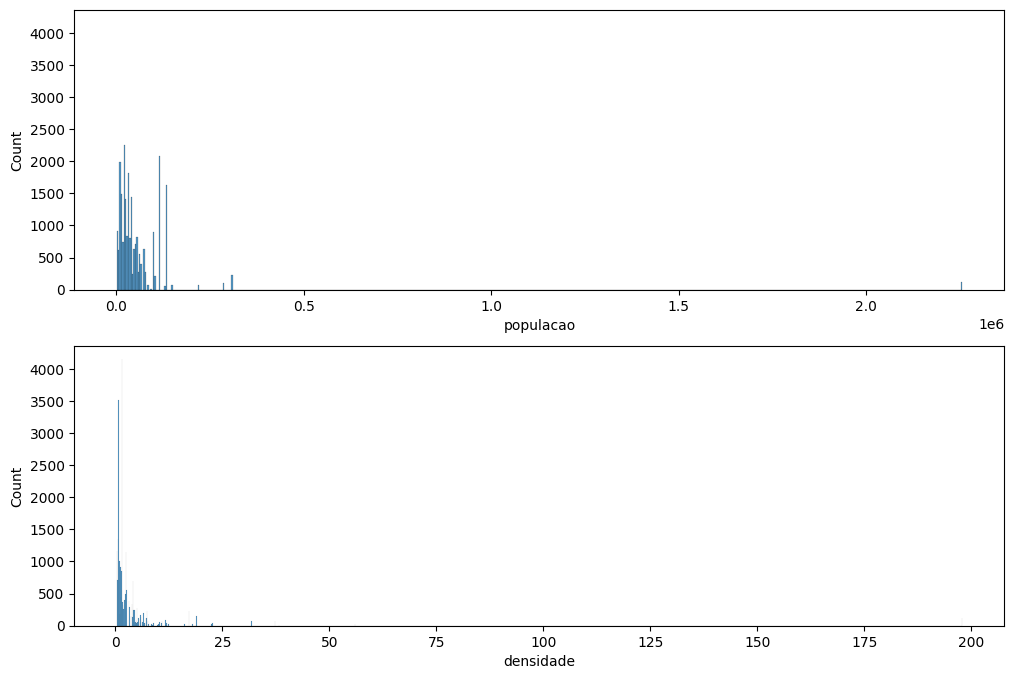

In [90]:
fig, ax = plt.subplots(2, figsize=(12, 8), sharey=True)
sns.histplot(data=df, x="populacao", ax=ax[0])
sns.histplot(data=df, x="densidade", ax=ax[1])

plt.show()

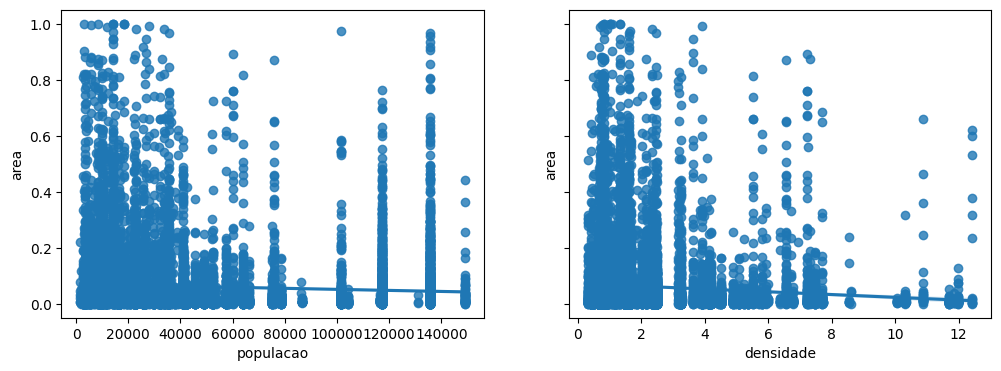

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.regplot(
    data=df[
        df["populacao"] < 2e5
    ], 
    x="populacao", 
    y="area", 
    ax=ax[0]
)
sns.regplot(
    data=df[
        df["densidade"] < 15
    ], 
    x="densidade", 
    y="area", 
    ax=ax[1]
)

plt.show()

In [ ]:
df[["densidade", "populacao", "area"]].fillna(0).corr()

,densidade,populacao,area
densidade,1.000000,0.936595,-0.010741
populacao,0.936595,1.000000,-0.016361
area,-0.010741,-0.016361,1.000000


No clear relation!

## And past deforestation?

In [108]:
pvt = pd.pivot_table(df[df["area"] > 0], columns="NM_MUN", index="quarter_date", values="area", aggfunc="sum").fillna(0)

In [131]:
s = pvt.iloc[:, 0].values

0.6638033833486229

In [133]:
def autocorr(s, lags=list(range(1, 9))):
    return [
        np.corrcoef(s[lag:], s[:-lag])[0, 1]
        for lag in lags
    ]
ac = pvt.apply(autocorr, axis=0)

c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\GiovanniAmorim\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is

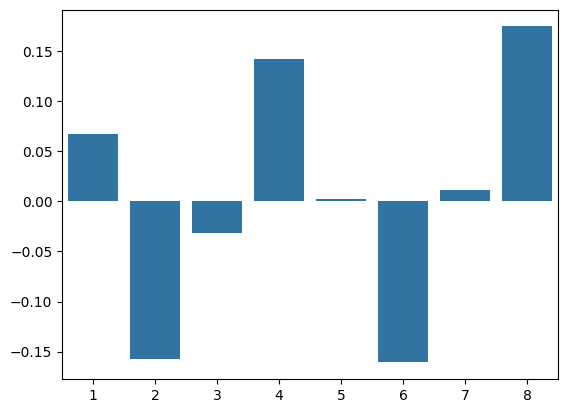

In [145]:
sns.barplot(
    x=list(range(1,9)),
    y=ac.mean(axis=1).values,
    color=sns.color_palette()[0]
)
plt.show()

Past deforestation from same county could be useful!